# Imports

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdrobust import rdplot
from rdrobust import rdrobust
from plotnine import *

# Methods

Methods for Identification 

In [323]:
def sign(x):
    """
    This function computes the sign of the given observation.

    Parameters
    ----------
    x : int
        The observation to compute the sign.

    Returns
    -------
    sign: int 
        Returns -1 if x is negative and 1 if nonnegative.
    """
    if x<0:
        return -1
    else:
        return 1

def treatment(x):
    """
    This function computes if an observation has received treatment.

    Parameters
    ----------
    x : int
        The observation to compute the treatment variable.

    Returns
    -------
    treatment: int 
        Returns 0 if observation x does not receive treatment and 1 if it does receive treatment.
    """
    if x<0:
        return 0
    else:
        return 1

def indicator(x):
    """
    This indicator function computes if an observation is within a distance of the threshold.

    Parameters
    ----------
    x : int
        The observation to compute the indicator value.

    Returns
    -------
    treatment: int 
        Returns 1 if observation x is within the distance and 0 if it is not.
    """
    if np.abs(x)<0.1:
        return 1
    else:
        return 0


def genT(X):
    """
    This function creates an array of treatment variables for a sample of observations.

    Parameters
    ----------
    X : arrray[int]
        The sample of observation to compute the treatment values for.

    Returns
    -------
    T: array[int]
        Returns an array with 1's and 0's for each observation depending on wether that observation received treatment.
    """
    T = {}
    for i in range(len(X)):
        T = np.append(T,treatment(X[i]))
    T = np.delete(T,0)
    return T
            


Methods for Generation of Outcomes: $Y_{i} = \mu(X_{i}) + \varepsilon_i$

$Y_{i}$ from Noak and Rothe 2023 donut RDD paper: 
$\newline \mu_N(x)=sign(x)*x^2-L*sign(x)((x-\delta*sign(x))^2-\delta^2*sign(x))*\boldsymbol{1}\{|x|<\delta\}$

In [324]:
def mu_noak(L,x):
    """
    This function generates the non-random part of outcome function with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part of the outcome value for that observation.
    """
    return sign(x)*np.power(x,2) - L*sign(x)*(np.power(x-0.1*sign(x),2)-np.power(0.1,2)*sign(x))*indicator(x)

def genY_noak(L,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with the DGP used by Noack and Rothe (NR) (2023).

    Parameters
    ----------
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_noak(L,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic $Y_{i}$ just with simple treatment effect: $\quad \mu_{B}(x)= \tau t$

In [325]:
def mu_basic(tau,x): 
    """
    This function generates the non-random part of the outcome function with a basic potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part the outcome value.
    """
    return tau*treatment(x)

def genY_basic(tau,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with a basic potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basic(tau,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

Basic linear outcomes ($Y_{i}$) plus simple treatment effect: $\quad \mu_{BL}(x)= \alpha + \beta x + \tau t$

In [326]:
def mu_basicLinear(tau,alpha,beta,x): 
    """
    This function generates the non-random part of the outcome function with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    x : int
        The observation to compute the non-random outcome value for.

    Returns
    -------
    mu: int
        Returns the non-random part the outcome value.
    """
    return alpha + beta*x + tau*treatment(x)

def genY_basicLinear(tau,alpha,beta,X,epsilon):
    """
    This function generates a sample of outcomes (Y_i's) with a basic linear potential outcomes framework DGP.

    Parameters
    ----------
    tau : int 
        The size of the treatment effect.
    alpha: int
        The intercept parameter of the equation.
    beta: int
        The slope parameter of the equation.
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    epsilon : arrray[int]
        The vector of random errors.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    Y = {}
    for i in range(len(X)):
        Y = np.append(Y,mu_basicLinear(tau,alpha,beta,X[i]) + epsilon[i])
    Y = np.delete(Y,0)
    return Y

# Sample Generation 

Seed Set-up

In [327]:
sd = np.random.default_rng(seed=42)
print(sd)

Generator(PCG64)


Generation of the Outcomes ($Y_{i}$) given the different DGP's

In [328]:
def genY(name, X, tau=0, L=0, alpha=0, beta=0):
    """
    This function generates a sample of observations from the given DGP

    Parameters
    ----------
    name: string
        The name of the DGP to use
    X : arrray[int]
        The sample of observation to compute the outcome values for.
    tau : int 
        The size of the treatment effect. For basic and basic linear model.
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
    alpha: int
        The intercept parameter of the equation. For basic linear model.
    beta: int
        The slope parameter of the equation. For basic linear model.

    Returns
    -------
    Y: arrray[int]
        Returns a vector with the outcome values.
    """
    epsilon = np.random.normal(0,0.5,len(X))
    if name == 'Noack':
        Y = genY_noak(L,X,epsilon)
    elif name == 'Basic':
        Y = genY_basic(tau,X,epsilon)
    elif name == 'Basic Linear':
        Y = genY_basicLinear(tau,alpha,beta,X,epsilon)
    else:
        return NameError('Type of GDP is not recognised')
    return Y

Generation os the Sample $X_i$'s and $Y_i$'s

In [341]:

def genSample(name, n, tau=0, L=0, alpha=0, beta=0, printPlot=True):
    """
    Generate random variable: running variables (X), outcomes (Y), and treatments (T)

    Parameters
    ----------
    name: string 
        the name of the DGP to use to generate the sample. 
        Options are: 'Noak', 'Basic', 'Basic Linear'.
    n: int
        the size of the sample
    tau : int 
        The size of the treatment effect. For basic and basic linear model.
        Default value: 0. 
    L : int
        The parameter used by NR to define the level of misspecification L={0,10,20,30,40}. For the Noack and Rothe model.
        Default value: 0. 
    alpha: int
        The intercept parameter of the equation. For basic linear model.
        Default value: 0. 
    beta: int
        The slope parameter of the equation. For basic linear model.
        Default valu: 0. 
    printPlot: boolean
        Defines if a plot is printed with the sample.
        Default value: False.

    Returns
    -------
    sample: DataFrame
        A dataframe object with the geneated Y (outcomes) and X (running variables) and given T (treatment variables)
    """
    X = np.random.uniform(-1,1,n)
    Y = genY(name, X, tau, L, alpha, beta)
    T = genT(X)

    # Create sample dataframe
    sample = pd.DataFrame({'Y': Y,'X': X,'T': T})
    sample.Y = sample.Y.astype(float)

    # Print plot
    if printPlot == True:
        plt.scatter(X,Y,s=6)
        plt.xlabel('X')
        plt.ylabel('$Y_{i}$')
        
    return sample

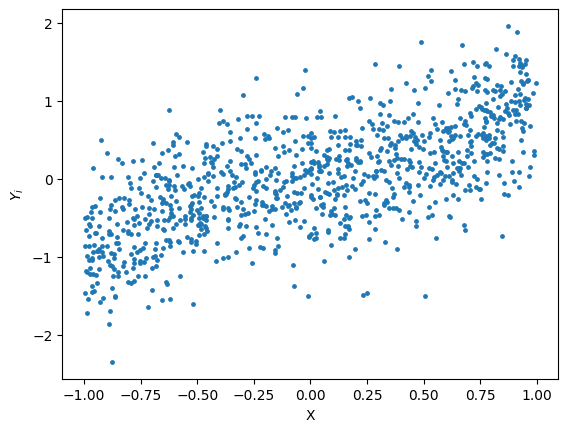

In [360]:
# Options are: 'Noak', 'Basic', 'Basic Linear'
sample = genSample('Noack',1000,0,printPlot=True)

# Simulation of Treatment Effects Estimation

In [363]:
rdrobust(sample.Y,sample.X,p=1)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           476        524
Number of Unique Obs.            476        524
Number of Effective Obs.         125        153
Bandwidth Estimation           0.282      0.282
Bandwidth Bias                 0.421      0.421
rho (h/b)                       0.67       0.67

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.029    0.139   -0.208   8.349e-01    [-0.302, 0.244]
Robust                 -        -   -0.142   8.868e-01    [-0.355, 0.307]


c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\rdrobust\rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


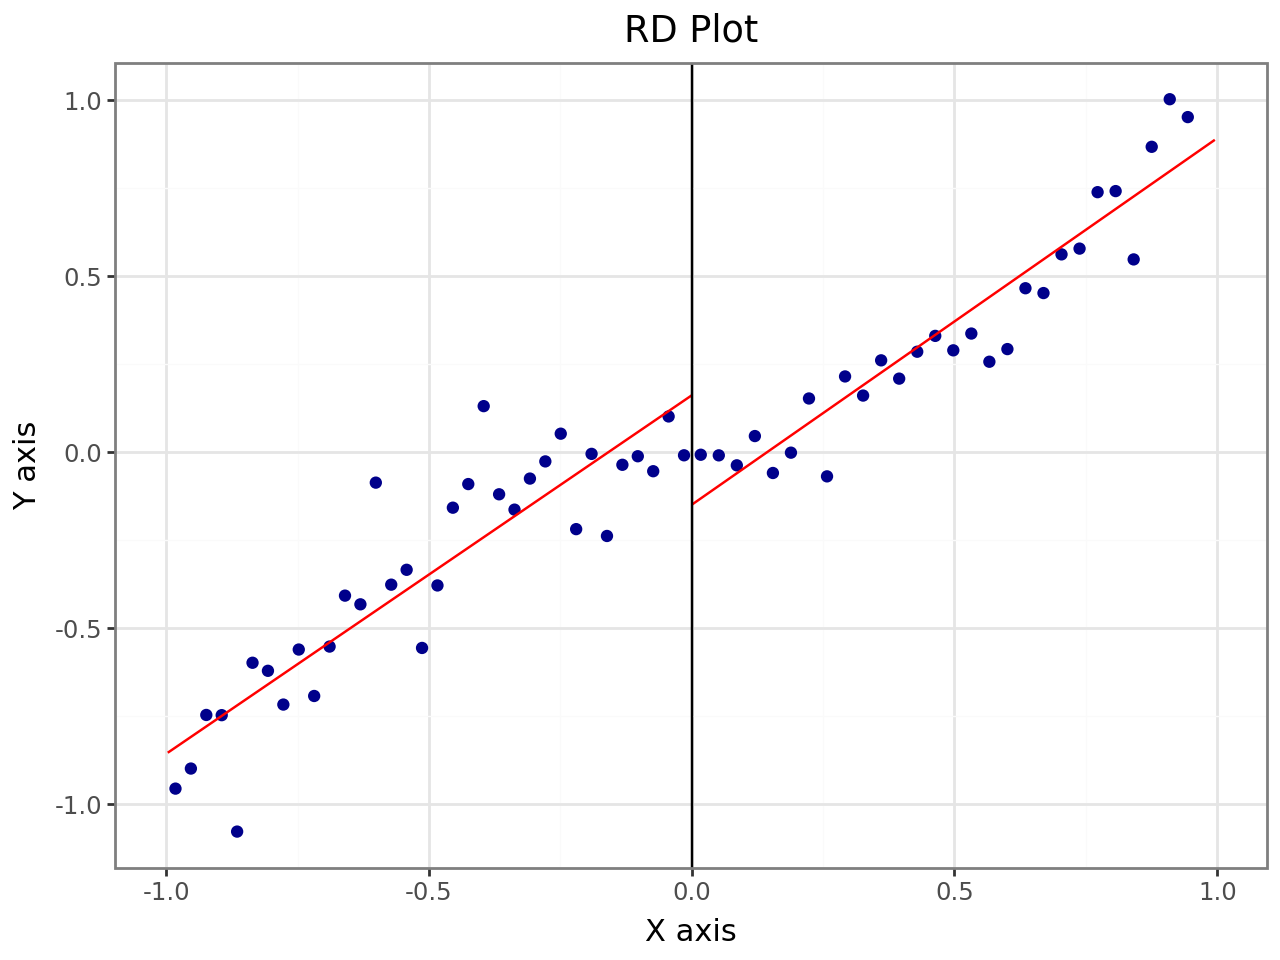


Call: rdplot
Number of Observations:                  1000
Kernel:                               Uniform
Polynomial Order Est. (p):                  1

                                Left      Right
------------------------------------------------
Number of Observations           476        524
Number of Effective Obs          476        524
Bandwith poly. fit (h)         0.997      0.995
Number of bins scale               1          1
Bins Selected                     34         29
Average Bin Length             0.029      0.034
Median Bin Length              0.029      0.034
IMSE-optimal bins                8.0        8.0
Mimicking Variance bins         34.0       29.0

Relative to IMSE-optimal:
Implied scale                   4.25      3.625
WIMSE variance weight          0.013      0.021
WIMSE bias weight              0.987      0.979


In [365]:
rdplot(sample.Y,sample.X,p=1)

In [333]:
n = 1000
L = np.array([0,10,20,30,40])
tau = 2
a = -1
b = 1

In [334]:
def simulation(name,n,r,tau=0, L=0, alpha=0, beta=0):
    TE = {}
    for i in range(r):
        sample = genSample(name,n,tau, L, alpha, beta, printPlot=False)
        res = rdrobust(sample.Y,sample.X)
        TE = np.append(TE, res.coef.iloc[0])
    TE = np.delete(TE,0)
    return TE

In [368]:
TE = simulation('Noack',1000,1000,L=40)

In [369]:
np.mean(TE)

-0.5676801607741105

In [370]:
np.std(TE)

0.20420499617069152

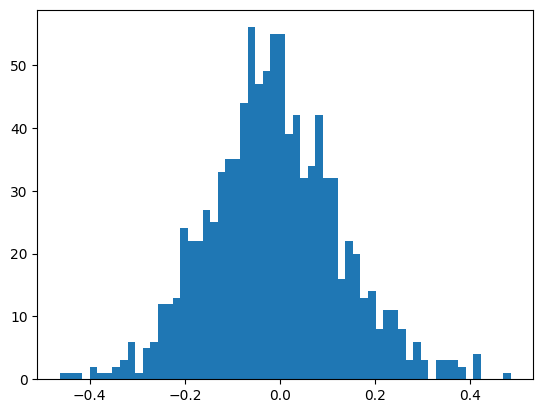

In [355]:
hist = plt.hist(TE, bins=60)